<div style="text-align: right">INFO 6105 Data Science Eng Methods and Tools, Lecture 5 Day 1</div>
<div style="text-align: right">Dino Konstantopoulos, 30 September 2019, with material by Neeraj Singh</div>

# Data Science with Bayesian Estimation

[Bayesian estimation](https://en.wikipedia.org/wiki/Bayes_estimator) is practical and effective today thanks to [MCMC](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) algorithms implemented in popular libraries like `PyMC3`, `Sampyl`, `Stan`, and others. 

We won't look at the details of the algorithm itself, but we'll look at the intuition behind it, using a bit of math, and introduce `Sampyl` as a simple version of probabilistic programming *so we don't have to do math*, and then in the next notebook we'll graduate to the more advanced `PyMC3` library for probabilistic programming. 

<div style="text-align: right; color: gray">1</div>

## Origins of Markov-Chain Monte Carlo (MCMC)

[**Markov Chains**](https://en.wikipedia.org/wiki/Markov_chain) are memorless [state machines](https://en.wikipedia.org/wiki/Finite-state_machine). We'll revisit these when we start our work on linear algebra with python.

[**Monte Carlo**](https://en.wikipedia.org/wiki/Monte_Carlo_method) methods were pioneered by [Manhattan Project](https://en.wikipedia.org/wiki/Manhattan_Project) scientists [Nicholas Constantine Metropolis](https://en.wikipedia.org/wiki/Nicholas_Metropolis), [John von Neumann](https://en.wikipedia.org/wiki/John_von_Neumann), and [Stanislaw Ulam](https://en.wikipedia.org/wiki/Stanislaw_Ulam), who helped develop the [first atomic weapon](https://en.wikipedia.org/wiki/Nuclear_weapons_of_the_United_States) in the 1940s. Also, some of the greatest computer scientists that *ever* lived! Read their bios..

- Faced with very limited supplies of uranium, they did what you did with games and turned to **simulation** to compute reliable probabilities for model parameters in order to reduce the amount of raw material needed for testing. Also: in order to not experiment on people (how do you compute the amount of shielding required to protect physicists from radiation? Put a a bunch of physicists in different rooms with different shieldings and see who dies and who doesn't?). 

[J. Robert Oppenheimer](https://en.wikipedia.org/wiki/J._Robert_Oppenheimer) was the wartime head of the [Los Alamos Laboratory](https://www.lanl.gov/) and is among those who are credited with being the "father of the atomic bomb", used in the atomic bombings of [Hiroshima and Nagasaki](https://en.wikipedia.org/wiki/Atomic_bombings_of_Hiroshima_and_Nagasaki), in Japan. The first atomic bomb was detonated on July 16, 1945, in the [Trinity test](https://en.wikipedia.org/wiki/Trinity_(nuclear_test) in New Mexico. Oppenheimer later remarked that it brought to mind words from the [Bhagavad Gita](https://en.wikipedia.org/wiki/Bhagavad_Gita): [Now I am become Death, the destroyer of worlds](https://www.wired.co.uk/article/manhattan-project-robert-oppenheimer).

</br >
<center>
<img src="ipynb.images/thanos.jpg" width=400 />
</center>


Oppenheimer's assistant was [Guido H. Sandri](https://www.bu.edu/eng/2013/07/29/remembering-a-collegial-renaissance-man/), and Guido was *your professor's* Ph.D. advisor at Boston University during my doctoral years, the head of my Ph.D. committee, and also the man that shaped my academic personality more than anybody else.

</br >
<center>
<img src="https://www.bu.edu/eng/files/news-cms/photos/sandri.jpg" width=200 />
Guido v.H. Sandri
</center>


<div style="text-align: right; color: gray">2</div>

## Bayesian inference

In Bayesian inference, our goal is to represent our *beliefs* with probability distributions (models), and to *update* our beliefs given data. The *less* certain we are about some prior belief, the *wider* the probability distribution. Conversely, the *stronger* the belief, the *narrower* the probability distribution. We use these probability distributions to quantify our knowledge about the parameters, including uncertainty, in our conclusions. 

We use Bayes’ theorem to model our degrees of belief (parameters $\alpha$, $\beta$, $\theta$, $\mu$, $\sigma$, etc.) of the analytic curves that represent the pdfs of our beliefs. That is, we have some beliefs (and knowledge) about model parameters before we see data, then we *update* our beliefs *after* seeing the data. Bayes’ theorem relates information given by the data (the data likelihood) with prior knowledge of the parameters before seeing data (the prior). The data and the priors are used to calculate the probability distribution of model parameters after seeing the data (the posterior).

We leverage Bayes’ theorem to model our belief. That is, we have some beliefs (and knowledge) about model parameters before we see data, then we update our beliefs after seeing the data. 






<div style="text-align: right; color: gray">3</div>

## The pain in Bayes' formula

Lets take a close look at **Bayes' formula**:



$$p(\theta \; | \; x) = \frac{p(x \; | \; \theta) . p(\theta)}{p(x)}$$

We have $p(\theta \; | \; x)$, the probability of our model parameters $\theta$ *given the data* $x$ and thus our quantity of interest. To compute this we multiply the prior $p(\theta)$ (what we think about $\theta$ before we have seen any data) and the likelihood $p(x\; | \; \theta)$, i.e. how we *think* our data is distributed. This nominator is pretty easy to solve for. Easy-peasy.

However, lets take a closer look at the denominator. $p(x)$ which is also called the **evidence** (i.e. the evidence that the data $x$ was generated by this model). 

How to compute? 

By the law of total probability, we can compute this quantity by integrating over all possible $\theta$ parameter values:

$$p(x) = \int_\theta p(x, \theta) d\theta$$

This is the *key* difficulty with Bayes formula -- while the formula looks innocent enough, for even slightly non-trivial models you just can't compute $p(x)$, and thus the posterior $p(x\; | \; \theta)$ in a closed-form way.

Any way we can use a formula that can get rid of this pesky term? That's exactly what the Metropolis algorithm does!



<div style="text-align: right; color: gray">4</div>

## Monte Carlo methods to the rescue


Let's approximate $\theta$ by trying different values for ir!

Embed yourself in the space of all possible parameters $\theta$. How do you move in that parameter space, generating different versions of $p(x\; | \; \theta)$, and then finding the right one, i.e. the right point in $\theta$ space that yields the right estimation of $p(x\; | \; \theta)$ we're after? How would you do this with a **genetic algorithm** (GA)?

Well, you start at *one* random point in $\theta$ space, and move around, right? You move (jump) from that position to somewhere else, using some randomness (that's the **Monte Carlo** part). 

*How* you move is the real smart part (that's the **Markov Chain** part): The ratio of the posteriors at one point and the next in state space as we walk through it gets rid of the pesky $p(x)$ above which we cannot compute! Without that pesky term you *can* compute that ratio, and that also gives you the ratio of the posteriors without having to evaluate the pesky term. 

Additionally, if you make that ratio the probability of moving from one point to the next (accepting it sometimes, rejecting it other times), then you keep visiting regions of ***high posterior probability*** relatively **more often** than those of lower posterior probability: *always* accept the jump if the posterior probability gets higher, and otherwise accept it sometimes or not with probability = the ratio, if the posterior gets lower. Isn't that a clever way to traverse state space?! It ensures our fitness function is monotonically *increasing*, which we saw was ***a prerequisite for convergence of genetic algorithms***. And that's what GA do: they traverse state space of all possible solutions in a clever way.

If I'm a bee and I get a strong whiff of pollen, always fly in that direction, otherwise roll a dice in my bee-head and fly in the direction given by the dice.

Guess what... eventually all roads lead to *Rome*, and you will find your fragrant flowers, or that point in $\theta$ state space that *maximizes* the posterior probability. And that's exactly what we want: To find the values of model parameters that maximize the posterior. That's the right estimation of $p(x\; | \; \theta)$.

The Metropolis algorithm, see [here](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm), is just as important and interesting of an algorithm as *k-means*.

The inventor of Metropolis? [Nicholas Constantine Metropolis](https://en.wikipedia.org/wiki/Nicholas_Metropolis) (Greek: Νικόλαος Μητρόπουλος, June 11, 1915 – October 17, 1999), a Greek-American physicist at Los Alamos in the 1950s, where, together with a group of researchers including [John von Neumann](https://en.wikipedia.org/wiki/John_von_Neumann) and [Stanislaw Ulam](https://en.wikipedia.org/wiki/Stanislaw_Ulam), developed this method. For many years MC methods were the domain of physicists and chemists. They really didn't come into prominence in general statistics until we started generating, as a species, so much data that simulation made sense! A quarter century ago?

Nicholas Metropolis authored the 1953 paper Equation of State Calculations by Fast Computing Machines, abridged [here](https://en.wikipedia.org/wiki/Equation_of_State_Calculations_by_Fast_Computing_Machines) and can be found [here](https://bayes.wustl.edu/Manual/EquationOfState.pdf), together with [Arianna W. Rosenbluth](https://en.wikipedia.org/wiki/Arianna_W._Rosenbluth), [Marshall Rosenbluth](https://en.wikipedia.org/wiki/Marshall_Rosenbluth), [Augusta H. Teller](https://en.wikipedia.org/wiki/Augusta_H._Teller) and [Edward Teller](https://en.wikipedia.org/wiki/Edward_Teller) (the father of the [Hydrogen bomb](https://en.wikipedia.org/wiki/Thermonuclear_weapon)). This paper proposed the algorithm for the case of symmetrical proposal distributions, and [W. K. Hastings](https://en.wikipedia.org/wiki/W._K._Hastings) extended it to the more general case in 1970.

Nicholas Metropolis had coined the term "Monte Carlo" in an earlier paper with Stanislav Ulam, and led the group in the Theoretical Division that designed and built the [MANIAC I](https://en.wikipedia.org/wiki/MANIAC_I) computer used in the experiments in 1952. Edward Teller states in his memoirs that the five authors of the 1953 paper worked together for "days (and nights)". According to [Roy Glauber](https://en.wikipedia.org/wiki/Roy_J._Glauber) and [Emilio Segrè](https://en.wikipedia.org/wiki/Emilio_Segr%C3%A8) however, the original algorithm was invented by [Enrico Fermi](https://en.wikipedia.org/wiki/Enrico_Fermi) and was reinvented by Stan Ulam.

The names of the principal actors are *giants* in physics and computation, and I suggest you follow the Wikipedia hyperlinks and learn about the seminal work that confirmed that human is the cruelest of animals. 

<div style="text-align: right; color: gray">6</div>

## Flipping a coin

Let' do a **Monte Carlo** (MC) simulation of flipping a coin. Let's start with 10 flips, then 100, then 1000.

</br >
<center>
<img src="images/tosscoin.png" width=150 />
</center>

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pylab as plt
import seaborn as sns
sns.set_context('notebook')

RANDOM_SEED = 20090425

[1 1 0 1 0 0 0 1 1 1 1 0 0 1 1 1 1 0 0 1 1 1 1 0 0 1 0 0 0 0 1 1 1 0 0 0 0
 0 0 1 0 0 0 0 0 1 0 0 1 1 1 0 1 0 0 1 1 0 1 0 0 0 0 1 0 0 0 1 1 0 0 1 0 1
 0 0 0 0 1 1 1 0 1 0 0 1 0 1 0 0 0 1 1 0 0 1 1 0 1 0 0 1 1 0 0 1 0 1 0 1 1
 1 0 0 0 0 1 0 0 1 1 1 0 1 1 1 1 1 0 0 1 0 0 0 1 0 1 0 0 1 0 1 1 0 0 1 1 0
 0 1 1 1 1 0 0 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 1 0 1 1 1
 0 1 0 0 1 0 0 0 1 0 0 1 1 0 0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 0 0 1 0 0 1 1
 1 1 1 0 1 1 0 1 0 1 0 0 0 0 0 1 1 1 0 1 0 1 0 1 1 1 1 0 0 0 1 0 1 1 1 0 1
 0 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 0 0 1 1 0 1 1 1 0 1 0 1 1 1 1 0 0 0
 1 1 0 0 1 0 1 0 1 1 0 0 0 1 1 0 0 1 1 1 0 1 0 0 1 1 0 0 1 0 1 0 1 1 1 0 0
 1 1 0 1 0 0 0 0 1 0 1 0 1 1 1 0 1 1 1 1 0 0 0 1 0 0 0 0 1 1 1 1 0 0 1 1 1
 1 1 0 1 0 1 1 0 1 1 0 1 1 0 1 1 1 0 0 0 1 0 1 0 1 1 1 0 0 1 1 0 0 0 1 0 0
 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1
 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 1 1 0 1 1 0 1 0 0 

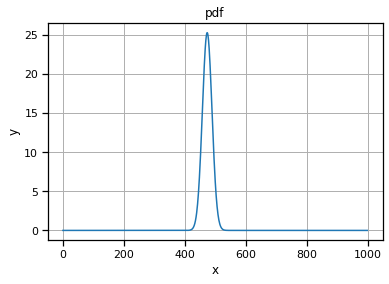

In [3]:
# our events is a list of 0s and 1s, at fixed probabilities
flipcoin = np.random.choice(a= [0, 1],
                              p = [0.5, 0.5],
                              size=1000)
print(flipcoin)
successes = flipcoin.sum()
failures = len(flipcoin) - successes

# prior parameters
alpha, beta = 1, 1

# calculate posterior distribution, using a beta distribution
posterior = stats.beta(alpha + successes, beta + failures)

# mean and 95% credible interval
mean = posterior.mean()
cr = posterior.interval(0.95)
print(cr)

#posterior distribution for plotting
xs = np.linspace(0, 1, num=1000)
pdf = posterior.pdf(xs)
plt.plot(pdf)
plt.xlabel('x')
plt.ylabel('y')
plt.title('pdf')
plt.grid(True)
plt.show()


Yup, that looks like the pdf that approximates the probabilities of coin tossing gets *tighter* and *tighter* the more data we have (the more flip coin events we record).

<div style="text-align: right; color: gray">7</div>

# Flaws of frequentist statistics

**Frequentist Statistics** tests whether an event (hypothesis) occurs or not. It calculates the probability of an event in the **long run** of the experiment (i.e the experiment is repeated under the same conditions to obtain the outcome).

Here, the sampling distributions of fixed size are taken. Then, the experiment is theoretically repeated an infinite number of times but practically done with a stopping intention. 

For example, I perform an experiment with a stopping intention in mind that I will stop the experiment when it is repeated 1000 times, or I see minimum 300 heads in a coin toss. 

Now, what if person A chooses to stop tossing a coin when the total count reaches 100 while person B stops at 1000? For different sample sizes, we get different t-scores and different p-values! Similarly, intention to stop may change from fixed number of flips to total duration of flipping. In this case too, we are bound to get different p-values.

This experiment presents us with a very common **flaw** of the frequentist approach, i.e. dependence of the result of an experiment on the number of times the experiment is repeated.

Frequentist statistics suffer other design and interpretation flaws. We recap them here:

- **p-values** measured against a sample (fixed size) statistic with some stopping intention changes with change in intention and sample size. i.e If two persons work on the same data and have different stopping intention, they may get two different  p- values for the same data, which is undesirable.

- **Confidence Intervals** (C.I), like p-values, depend heavily on the sample size. This makes the stopping potential absolutely absurd since no matter how many persons perform the tests on the same data, the results should be consistent.

- Confidence Intervals (C.I) are not **probability distributions** and therefore they ***do not*** provide the most probable value for a parameter and the most probable values.

These three reasons are *enough* to get you going into thinking about the drawbacks of the frequentist approach.

<div style="text-align: right; color: gray">8</div>

# Bayesian example

Suppose, out of all the 4 championship races (F1) between Lewis Hamilton (Mercedes) and Charles Leclerc (Ferrari), Lewis won 3 times while Charles managed only 1.

So, if you were to bet on the winner of next race, who would he be ?

I bet you would say LH.

Now what if you are told that it rained **once** when Lewis won and **once** when Charles won and it is definite that it will rain on the next date. So, who would you bet your money on now, Mercedes or Ferrari?

By intuition, it is easy to see that chances of winning for Charles have increased drastically. By how much?

Suppose, B is the event of a Charles Leclerc win, and A is the event of raining. Therefore,

P(A) =1/2, since it rained twice out of four days.
P(B) is 1/4, since Charles won only one race out of four.
P(A|B)=1, since it rained every time when Charles won.

Substituting the values in the conditional probability formula:

$$p(B\;|\;A) = \frac{p(A\;|\;B) \; p(B)}{p(A)}$$

we get the probability to be 50%, which is ***almost the double of 25% when rain was not taken into account***!

This further strengthened our belief of Charles winning ***in the light of new evidence*** i.e **rain**. 

<div style="text-align: right; color: gray">9</div>

# Bayes Theorem

Bayes Theorem comes into effect when multiple events $A_i$ form an exhaustive set with another event $B$:

$B$, a union of probabilities conditional over a set of events $A_i$, can be written as:

$$B = \sum_{i=1}^n B \cap A_i$$

For example, you may think of $B$ as Mercedes winning the 2019 season trophy race given conditions $A_i$ (LH wins the point trophy, VB wins the points trophy, Ferrari wins but they cheated so they're DQed, etc.).

So, probability of B can be written as:

$$p(B) = \sum_{i=1}^n p(B \cap A_i)$$

By the law of probability **intersections** (assuming independence of events):

$$p(B \cap A_i) = p(B\;|\;A_i) \; p(A_i)$$

So, we get:

$$p(A_i\;|\;B) = \frac{p(B\;|\;A_i) \; p(A_i)}{\sum_{i=1}^n p(B \cap A_i)}$$

and finally:

$$p(A_i\;|\;B) = \frac{p(B\;|\;A_i) \; p(A_i)}{\sum_{i=1}^n p(B\;|\;A_i) \; p(A_i)}$$

***that*** is **Bayes' formula**!

<div style="text-align: right; color: gray">10</div>

# Why Bayesian inference is superior to classical hypothesis testing

Models are the mathematical formulation of the observed events. Parameters are the factors in the models affecting the observed data.

In tossing a coin, **fairness** of coin may be defined as the parameter denoted by $θ$. The outcome of the events may be denoted by $D$.

Answer this now. What is the probability of 4 heads out of 9 tosses ($D$) given the fairness of coin ($θ$). i.e $p(D|θ)$?

Actually, let's talk about * the converse problem*: Given an outcome (D) what is the probability of coin being fair ($p(θ)=0.5$)

Let's represent it using Bayes Theorem:

$$p(θ|D)=\frac{p(D|θ) \; p(θ)}{p(D)}$$

Here, $p(θ)$ is the **prior** i.e the strength of our belief in the fairness of coin before the toss. It is perfectly okay to believe that coin can have any degree of fairness between 0 and 1.

$p(D|θ)$ is the **likelihood** of observing our result given our distribution for θ. If we knew that coin was fair, this gives the probability of observing the number of heads in a particular number of flips.

$p(D)$ is the **evidence**. This is the probability of our data as determined by summing (or integrating) across all possible values of θ, ***weighted by how strongly we believe in those particular values of $θ$***.

If we had multiple views of what the fairness of the coin is (but didn’t know for sure), then this tells us the probability of seeing a certain sequence of flips for all possibilities of our belief in the coin’s fairness.

$p(θ|D)$ is the **posterior** belief of our parameters ***after observing the evidence*** i.e the number of heads.

To define our model correctly , we need **two** mathematical models beforehand. One to represent the likelihood function $p(D|θ)$, and the other for representing the distribution of prior beliefs. The product of these two gives the posterior belief $p(θ|D)$ distribution.

Since prior and posterior are both beliefs about the distribution of fairness of coin, intuition tells us that both should have the same mathematical form.

$p(y=1|θ)=$ If coin is fair $θ=0.5$, probability of observing heads (y=1) is 0.5.

$p(y=0|θ)=$ If coin is fair $θ=0.5$, probability of observing tails (y=0) is 0.5

We can combine the above mathematical definitions into a single definition to represent the probability of both outcomes. It's the [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution) for a **single trial**.

$$P(y|θ)= θ^y \; (1-θ)^{1-y}$$

This is called the [Bernoulli Likelihood Function](https://en.wikipedia.org/wiki/Bernoulli_distribution) and the task of coin flipping is called [Bernoulli’s trials](https://en.wikipedia.org/wiki/Bernoulli_trial).

And, when we want to see a **series of heads or flips**, its probability is given by:

$$p(y_1, y_2, \cdots, y_n \; |\;θ) = \prod_{i=1}^n p(y_i \; |\;θ) = \prod_{i=1}^n θ^y \; (1-θ)^{1-y}$$

So, the probability of number of heads $z$ turning up in $N$ number of flips ($y=1$ $z$ times for $n = N$, and $y=0$ $N-k$ times in the formula above), is the **binomial distribution**:

$$p(z, N \; |\;θ) =  θ^z \; (1-θ)^{N-z}$$

The mathematical function used to represent prior belief $p(\theta)$ ***with the most uninformative priors possible*** is known as the [beta distribution](https://en.wikipedia.org/wiki/Beta_distribution). It has some very nice mathematical properties which enable us to model beliefs about a binomial distribution. We'll study this distribution soon.

f we use the probability density function (pdf) of the beta distribution for $p(\theta)$, it is of the form:

$$p(\theta) = \frac{x^{\alpha - 1}\;(1-x)^{\beta - 1}}{B(\alpha, \beta)}$$

$B$ is just to ensure that the total probability density function upon integration evaluates to 1. 

$α$ and $β$ are called the shape-deciding parameters of the density function. Here $α$ is analogous to number of heads in the trials and $β$ corresponds to the number of tails.

$α$ and $β$ are intuitive to understand since they can be calculated by knowing the mean ($μ$) and standard deviation ($σ$) of the distribution. they are related as so:

$$μ = \frac{\alpha}{\alpha + \beta}$$

$$σ = \sqrt{\frac{\alpha \; \beta}{(\alpha + \beta)^2\; (\alpha + \beta + 1)}}$$

When there is no toss (no observations yet), we believe that the coin is fair as depicted by the flat line in the first graph below.

When there are tosses (observations) and a bigger number of heads than tails, the graph shows a **peak** shifted towards the *right side*, indicating higher probability of heads, ***and that coin is not fair***.

As more tosses are observed, and tails come in to balance out the heads, the peak narrows and the mean value of the distribution shifts to the middle, increasing our confidence in the fairness of the coin.

</br >
<center>
<img src="images/trials-heads.png" width=800 />
</center>

This experiment is entirely similar to the winning distribution of Lewis Hamilton. As the season gets underway, LH may be out of shape and he looses races, and his pdf is skewed towards the losing side, and maybe we don't believe in the power of the Hamilton anymore... But as the season stretches on, LH starts winning again, and his pdf starts shifting towards the winning side, past the mean value for any F1 racer.

Why did we pick a beta distribution for the prior $p(\theta)$? Because when we multiply it with a likelihood function, posterior distribution yields a form similar to the prior distribution, which is much easier to relate to and understand. So we kind of *cheated*, and it kind of worked out, didn't it? 

Now, let’s calculate **posterior belief** using Bayes theorem and the binomial distribution and beta distributions as depicted above:

$$p(θ\;|\;z, N) = \frac{p(z,N\;|\;θ) \; p(θ)}{p(z,N)}$$

$$p(θ\;|\;z, N) = \frac{θ^z \; (1-θ)^{N-z} \; θ^{\alpha - 1} \; (1-θ)^{\beta - 1}} {B(\alpha, \beta)\; p(z,N)}$$

$$p(θ\;|\;z, N) = p(θ\;|\;z + \alpha, N - x + \beta) $$

So, just knowing the mean $\mu$ and standard deviation $\sigma$ (and thus $\alpha$ and $\beta$) of our prior belief $p(θ)$ and by observing the number ($z$) of heads in $N$ flips, we can update our belief (that's our ***posterior***) about the model parameter $θ$. ***Analytically***!

Here's a data experiment: Suppose, you think that a coin is **biased**. It has a mean ($μ$) bias of around 0.6 with standard deviation of 0.1 (so it's not *fair*!).

Then from the formulas above,

$α$= 13.8 , $β$=9.2

and our distribution is biased on (*skewed towards*) the right side. 

Suppose now you observe 80 heads ($z=80$) in 100 flips($N=100$). We have our **before** and **after**, let’s compute our prior and posterior beliefs:

**prior** = $p(θ\;|\;α,β) = p(θ\;|\;13.8,9.2)$

**posterior** = $p(θ\;|\;z+α,N-z+β) = p(θ\;|\;93.8,29.2)$

As more and more flips are made and new data is observed, our beliefs get **updated**. ***This is the real power of Bayesian Inference***.


If you don't care about flipping coins, think about F1. As the F1 season gets  under way, LH may be in not-so-good shape and *loose* a few races before getting in shape and winning again. His pdf, at the end of the season, we know is skewed towards winning, but at the start of the season, that may not be the case. As the season progresses and new evidence comes in (LH wins), the LH pdf sharpens into the pdf we expect from LH from past seasons.

In a **frequentist** World view, data observed is considered random, but model parameters are considered **fixed**. How is that possible when our belief about the magic of the Hamilton changes depending on the number of his wins in the current F1 season? *Soooooooo wrong*! Our model parameters *cannot* be fixed! In a **Bayesian** World view, data is considered fixed and model parameters are treated as random variables with probability distributions. I *liiiiiiiiike that*!

### p-value

Suppose the **t-score** for a particular sample from a sampling distribution of fixed size is calculated. Then **p-values** are predicted. We can interpret p-values as (taking an example of p-value as 0.02 for a distribution of mean 100): There is 2% probability that the sample will have mean equal to 100.

This interpretation suffers from the **flaw** that for sampling distributions of different sizes, one is bound to get different t-score and hence different p-value. It is *absurd*! A p-value less than 5% does not guarantee that null hypothesis is **wrong** nor a p-value greater than 5% ensures that null hypothesis is **right**!!

### confidence intervals

**Confidence Intervals** also suffer from the same defect. Moreover since C.I is not a probability distribution , there is no way to know which values are most probable.

### Bayes factor

The [Bayes factor](https://en.wikipedia.org/wiki/Bayes_factor) is the equivalent of [p-value](https://en.wikipedia.org/wiki/P-value) in the Bayesian framework.

When $θ$ is the probability LH wins the F1 overall trophy for the season, the **null hypothesis** in a Bayesian framework assumes $∞$ probability distribution *only* at a particular value of a parameter (say $θ=0.5$) and a zero probability elsewhere. The **alternative hypothesis** is that ***all values of $θ$ are possible***, hence a **flat curve** representing the distribution. That's what we start with at the beginning of the F1 season: we have no idea if LH is going to win. It's 50-50.

As the season gets underway, Bayesian statistics adjust credibility (probability) of of $θ$ as we observe more data (F1 grand prix results). It can be seen that the probability distribution for LH is shifting towards the **alternative hypothesis** with a value higher than the **null hypothesis**. i.e. the alternative hypothesis is likely: We have higher and higher conviction that LH is going to win the season.

Bayes factor does not depend upon the actual distribution values of $θ$, but only the magnitude of the shift in values for each hypothesis.

In panel A below: left bar is the prior probability of the **null hypothesis** and the right bar the probability of the **alternative hypothesis**. Same as in panel B, but the bars have different shapes. F1 season starts and ***we don't know who's going to win*** (prior). As the season progresses, probability that LH wins gets higher and higher (posterior).

</br >
</br >
<center>
<img src="ipynb.images/prior-posterior.png" width=600 />
</center>

**Bayes factor** is defined as the ratio of the posterior odds to the prior odds:

$$BF = \frac{p(NH\;|\;z, N)}{p(AH\;|\;z, N)} = = \frac{p(NH)}{p(AH)}$$

Where $NH$ represents the **null hypothesis** and $AH$ the **alternative hypothesis**.

To reject a null hypothesis, a $BF < 0.1$ is *preferred*. The immediate benefits of using the **Bayes Factor** instead of **p-values** is that the BF is **independent of intentions and sample size**.

### High Density interval (HDI)

The **High Density Interval** (HDI) is formed from the **posterior distribution** after observing new data (more F1 grand prix results). Since HDI is a probability, the 95% HDI gives the 95% most credible values. It is also guaranteed that 95 % values will lie in this interval, unlike C.I.

Notice how the 95% HDI in prior distribution is wider than the 95% posterior distribution. This is because our belief in HDI increases upon observation of new data:

</br>
</br >
<center>
<img src="images/hdi.png" width=400 />
</center>

Thanks to [Neeraj Singh](https://www.analyticsvidhya.com/blog/2016/06/bayesian-statistics-beginners-simple-english/) for a great introduction to the Bayes factor, reproduced (slightly improved) above.

<div style="text-align: right; color: gray">11</div>

## Experiment: Horny Boston Sloths

Let's run an experiment using Bayesian estimation, and a ***simple*** probabilistic library.

We want to compare the number of times Boston sloths become **romantic** after we introduce a new drug that is supposed to be a sloth [aphrodisiac](https://en.wikipedia.org/wiki/Aphrodisiac). Does it work?. We have a **before** and **after** distribution of how many times a week sloths engage in romantic acts. So we have a [bivariate](https://en.wikipedia.org/wiki/Function_(mathematics)#Multivariate_function) data experiment (`before` and `after` parameters). 


</br >
<center>
<img src="images/slothskissing.jpg" width=300 />
</center>

Instead of using classical frequentist statistical estimation theory, we'll use a **Bayesian model**. That means that instead of finding model parameters as **point estimates**, we'll identify model parameters as **pdfs**.

Consider an indexed collection of random variables $y_{1},\ldots ,y_{n}$. The joint probability distribution for $y_1, y_2, \ldots$ is a probability distribution that gives the probability that each of $y_1, y_2, \ldots$ falls in any particular range or discrete set of values specified for that variable. In the case of only two random variables, this is called a bivariate distribution, but the concept generalizes to any number of random variables, giving a multivariate distribution. Applying the chain rule and Bayes' theorem yields:

$$p(\theta \; | \; (y_i)_{i=1}^n) = \prod_{i = 1}^n p(y_i \; | \; \theta) . p(\theta)$$

So multivariate distributions in Bayes' estimation is piece of cake... Just **products** of univariate distributions (assuming independent random variables). So, let's simpligy and pick a univariate distribution: a **single** random variable $R$ (romance).

Let's build a Bayesian model using a [**Poisson**](https://en.wikipedia.org/wiki/Poisson_distribution) likelihood with **exponential** priors for $\lambda_1$ and $\lambda_2$. 

Ok, what does *that* mean, professor? 

That means we assume sloth acts of romance ($R$) per week are bunched up around a certain statistic, per Poisson, before ($\lambda_1$) and another statistic after ($\lambda_2$), and we are going to traverse $\lambda$ state space ***exponentially*** to try to locate the best $\lambda$s (the best parameters for our *before* and *after* Poissons). 

Let's recap: 
- Our model is a **Poisson** pdf
- The model parameter is $\lambda$
- We have two models (thus two parameters): before aphrodisiac, and after
- We want to find the optimal values of the parameters
- Since we're dealing with Bayesian statistics, we'll model these two parameters as pdfs
- Our walks through state space to find solutions for the parameters will be exponential (not in speed, but in trajectory). 

By Bayes' law:

$$
p(\lambda_1, \lambda_2 \mid R) \;\propto p( R \mid \lambda_1, \lambda_2)\, p(\lambda_1)\, p(\lambda_2) \;\;\; \text{(no denominator!)}\\
p( R \mid \lambda_1, \lambda_2) \;\sim \mathrm{Poisson}(R\mid\lambda_1)\,\mathrm{Poisson}(R\mid\lambda_2) \\
p(\lambda_1) \;\sim \mathrm{Exp}(\lambda) \\
p(\lambda_2) \;\sim \mathrm{Exp}(\lambda) 
$$

This analysis method we'll follow is known as `Bayesian estimation` using probabilistic programming. 

We have the equations above,and we want to know *likely* values for $\lambda_1$ and $\lambda_2$. This information is contained in the posterior distribution $p(\lambda_1, \lambda_2 \mid R)$. To infer values for $\lambda_1$ and $\lambda_2$, we sample from the posterior using MCMC samplers. Let's use the [Metropolis](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) algorithm. No more math! *Programming*, instead!

<div style="text-align: right; color: gray">12</div>

## Sampyl

`PyMC3` is not the only MCMC package. `Sampyl` is another, simpler one. [Read](https://pypi.org/project/sampyl-mcmc/) about it. [Here](http://matatat.org/sampyl/introduction.html) too. Let's install it. Better use an Anaconda terminal. If that does not work, try the below.

In [4]:
!pip install sampyl-mcmc

We don't have data for romantic adventures of Bsont sloths! So, we ***make up the data*** using two Poisson distributions, one with parameter 7 (before aphrodisiac), the other with parameter 9 (after aphrodisiac). So, we're cheating!

(yes, professor can do that, ***you cannot*** :-)

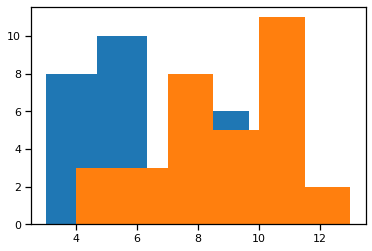

In [5]:
# Fake data for the day before and after aphrodisiac introduction into Boston sloth population
# Let's be conservative and assume that the aphrodisiac will increase acts of romance by 2 per week. Let's record data weekly.
before = np.random.poisson(7, size=32)
after = np.random.poisson(9, size=32)
plt.hist(before, bins='auto')
plt.hist(after, bins='auto')

# Define the log-P function here
def logp(λ1, λ2):
    model = smp.Model()
    # Poisson log-likelihoods
    model.add(smp.poisson(before, rate=λ1),
              smp.poisson(after, rate=λ2))

    # Exponential log-priors for rate parameters
    model.add(smp.exponential(λ1),
              smp.exponential(λ2))
    
    return model()

Let's MCMC-simulate with `Sampyl`. We seed our starting condition with point estimates from the classical method called **M**aximum **A** **P**osteriori estimation (MAP). It's pretty similar to MLE.

Then we say simulate for 10,000 timesteps and throw away the first 2,000 timesteps. Then give us statistical results of our simulation.

In [6]:
import sampyl as smp
from sampyl import np
    
start  =  smp.find_MAP(logp, {'λ1':1., 'λ2':1.})
sampler = smp.Metropolis(logp, start)
chain = sampler(10000, burn=2000, thin=4)

Progress: [##############################] 10000 of 10000 samples


In [7]:
print(sampler.var_names)

('λ1', 'λ2')


These are the **values** of the two $\lambda$s we simulated (the *values*, not the *pdf$s for each):

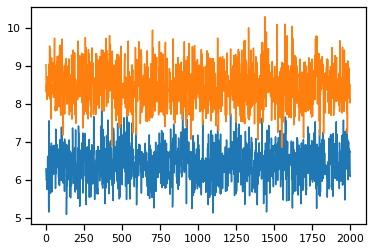

In [8]:
plt.plot(chain.λ1)
plt.plot(chain.λ2)

Now to see if there is a significant difference between **before aphrodisiac** and **after aphrodisiac**, we can look for the **difference** $\delta =  \lambda_2 - \lambda_1$, then find the probability that $\delta > 0$. Now let's find the pdf for $\delta$ by plotting the histogram of the difference between the simulated values of $\lambda_1$ and $\lambda_2$, and let's also plot a vertical line at $\delta = 2$ because we ***know that the difference between the two $\lambda$s should be 2***!

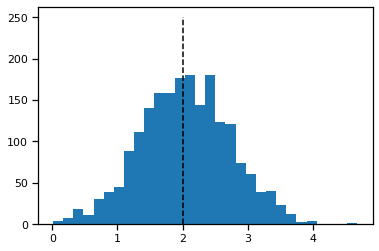

In [9]:
delta  = chain.λ2  - chain.λ1
_ =  plt.hist(delta, bins=30)
_ =  plt.vlines(2,  0,  250,  linestyle = '--')

Pretty close, huh?! 

Let's compute the probability that acts of romance **increased**: the difference between the means of before and after, and our confidence interval.

In [10]:
p  =  np.mean(delta  >  0)
effect  =  np.mean(delta)
CR  =  np.percentile(delta, (2.5, 97.5))
print("{:.3f} probability the rate of acts of romance increased".format(p))
print("delta = {:.3f}, 95% CR = {{{:.3f} {:.3f}}}".format(effect, *CR))

1.000 probability the rate of acts of romance increased
delta = 2.043, 95% CR = {0.663 3.384}


Wow, we are ***sure*** the acts of romance increased!

And what's the size of the difference? About 2.5 for a 95% confidence interval, where the true value lies in the intereval [1.17, 4].

The true difference in rates was two per hour, marked with the dashed line. We got it right!

Our posterior is showing an effect, and our best estimate is that the rate increased by about 2.5 acts of romance per week. The 95% credible region is [1.663 2.327] which idicates that there is a 95% probability that the true effect lies with the region, as it does.

### NUTS

Now, let's use the [NUTS](https://en.wikipedia.org/wiki/Stan_(software)#Algorithms) algorithm to sample from the posterior. We were told it's a cleverer (does that word exist?) algorithm..

D:\Anaconda3\lib\site-packages\autograd\tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


Progress: [##############################] 2100 of 2100 samples


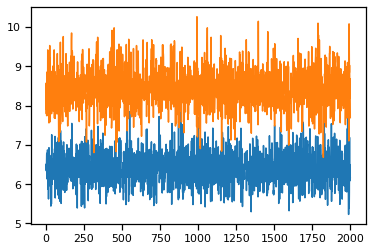

In [11]:
nuts = smp.NUTS(logp, start)
chain = nuts.sample(2100, burn=100)
_ = plt.plot(chain.λ1)
_ = plt.plot(chain.λ2)

1.000 probability the rate of weekly romantic acts increased
delta = 2.031, 95% CR = {0.782 3.268}


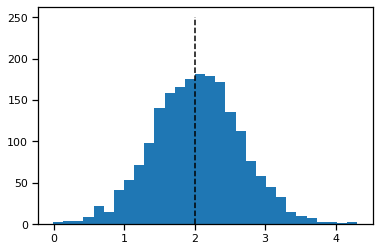

In [12]:
delta = chain.λ2 - chain.λ1
_ = plt.hist(delta, bins=30)
_ = plt.vlines(2, 0, 250, linestyle='--')
p = np.mean(delta > 0)
effect = np.mean(delta)
CR = np.percentile(delta, (2.5, 97.5))
print("{:.3f} probability the rate of weekly romantic acts increased".format(p))
print("delta = {:.3f}, 95% CR = {{{:.3f} {:.3f}}}".format(effect, *CR))

Exactly the same! I specified no random seed, so running it multiple times should generate different results, but the net effect and conclusion should be the same.

Bayesian estimation rocks! A bit complicated to understand what it means to use a model that is a pdf with parameters that ***are themselves pdfs***, but eventually I am sure you will understand it's just a more mathemtically correct way to give you an estimate of your model parameters because ***it also gives you an estimate of the amount of error*** you might be making in your modeling.

No crazy T-test or voodoo math!

# Conclusion

What's the **model** for the data you observe? That's the ***art*** of the statistician. You need to pick the right one. It;s the same in Machine Learning (ML): You need to pick the right model (CNN, RNN, etc.).

What are the parameters of your model? That's the ***science*** of the statistician. In **classical statistical estimation**, the parameters are **point estimates**, and if you want an error range, you need to do voodoo math like the **T-test**. In **Bayesian statistical estimation**, the parameters are ***pdf***s and thus naturally yield the probable value (the mean of the pdf), and its error (the standard deviation of the pdf).